## Galactic Pencilbeams Map 

In [36]:
from os import getenv, path
import numpy as np
import healpy as hp
from healpy.newvisufunc import projview, newprojplot
import science_priority_regions
import generate_galplane_priority_maps
from astropy_healpix import HEALPix
from astropy.coordinates import Galactic, TETE, SkyCoord
from astropy import units as u
import copy
import matplotlib.pyplot as plt
%matplotlib inline

Create an empty HEALpix map:

In [3]:
NSIDE = 64
ahp = HEALPix(nside=NSIDE, order='ring', frame=TETE())

By surveying a number of Rubin field pointings, all centered at Galactic Latitude ~0deg but distributed in Galactic Longitude between -85 to +85deg, we can ensure that we sample a range of stellar environments.  With the same observations, we also sample different lines of sight through the Galaxy, allowing us to directly compare their the populations of lenses, as well as a variety of variable stars, thus mapping Galactic structure.  To start with, we simulate an array of pointings:

In [4]:
Nbeams = 20
l_centers = np.linspace(-85.0, 85.0, Nbeams)
b_centers = [ 0.0 ]*len(l_centers)
print('Nominal pencil beam field centers (l,b [deg]):')
for i in range(0,len(l_centers),1):
    print(l_centers[i], b_centers[i])
print('Number of beams: '+str(Nbeams))

Nominal pencil beam field centers (l,b [deg]):
-85.0 0.0
-76.05263157894737 0.0
-67.10526315789474 0.0
-58.1578947368421 0.0
-49.21052631578947 0.0
-40.26315789473684 0.0
-31.315789473684205 0.0
-22.368421052631575 0.0
-13.421052631578945 0.0
-4.473684210526315 0.0
4.473684210526315 0.0
13.421052631578945 0.0
22.36842105263159 0.0
31.31578947368422 0.0
40.26315789473685 0.0
49.21052631578948 0.0
58.15789473684211 0.0
67.10526315789474 0.0
76.05263157894737 0.0
85.0 0.0
Number of beams: 20


Next we set the size of each field.  By default we assume that this is a single Rubin pointing, which has a radius of 1.75deg.  For simplicity, we set this to be the width and height of each field.

In [5]:
l_width = 1.75
b_height = 1.75

We can now calculate the HEALpixels included within the Rubin Field of View for this set of pointings:

In [6]:
for i in range(0,Nbeams,1):
    pixs = science_priority_regions.calc_hp_pixels_for_region(l_centers[i], b_centers[i], l_width, b_height, 500, ahp)

    if i == 0:
        region_pixels = pixs.flatten()
    else:
        region_pixels = np.concatenate( (region_pixels, pixs.flatten()) )

Let's plot a map to visualize what regions these nominal pointings would survey on-sky:

In [7]:
NPIX = hp.nside2npix(NSIDE)
vote_map = np.zeros(NPIX)
vote_map[region_pixels] = 1.0

0.0 180.0 -180.0 180.0
/var/folders/4z/rk7n9jss74g3shm9z6msmyvh0000gp/T/ipykernel_62405/1105161676.py:4: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


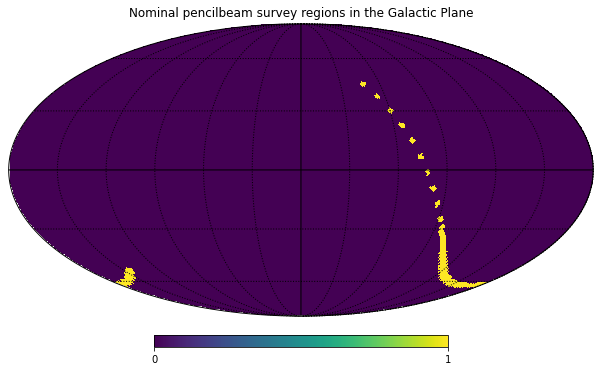

In [8]:
hp.mollview(vote_map, title="Nominal pencilbeam survey regions in the Galactic Plane",
                    min=0.0, max=1.0)
hp.graticule()
plt.tight_layout()

This gives us a uniformly-distributed set of pencilbeam fields across the Galactic Plane, but it does not take into account the non-uniform extinction in these areas.  Given that LSST is an optical survey, it makes more sense to refine the chosen pointings and recentre them on nearby fields with higher numbers of stars. To do this, we load a map of stellar density derived from the TRILegal galactic model and use the following function to optimize the pointings.

In [37]:
(star_density_hp, hp_log_star_density) = generate_galplane_priority_maps.create_star_density_map()
star_density_data = copy.deepcopy(hp_log_star_density)

In [10]:
def optimize_pointing_by_star_density(l_center, b_center, star_density_hp, hp_log_star_density,
                                      l_dither, b_dither):
    """Function to optimize the choice of field pointing by stellar density.  
    The initial pointing is dithered around (l_center, b_center) by +/-(l_dither, b_dither) and the 
    stellar density is derived for each dithered pointing from the galactic model.  The coordinates for 
    the pointing with the highest stellar density are returned."""
    
    Ndithers = 25
    min_l = max( (l_center-l_dither), -90.0 )
    max_l = min( (l_center+l_dither), 90.0 )
    min_b = max( (b_center-b_dither), -90.0 )
    max_b = min( (b_center+b_dither), 90.0 )
    
    l_pointings = np.linspace(min_l, max_l, Ndithers) * u.deg
    b_pointings = np.linspace(min_b, max_b, Ndithers) * u.deg
    
    LL,BB = np.meshgrid(l_pointings, b_pointings)
    input_coords = SkyCoord(l_center*u.deg, b_center*u.deg, frame=Galactic())
    coords = SkyCoord(LL, BB, frame=Galactic())
    pixels = star_density_hp.skycoord_to_healpix(coords)
    
    # Handle case where multiple nearby pointings have the same stellar density
    idx = np.where(hp_log_star_density[pixels] == hp_log_star_density[pixels].max())
    if len(idx[0]) > 1:
        idx = (idx[0][0], idx[1][0])
    
    best_coords = coords[idx].galactic
    
    print('Input coordinates: '+str(input_coords))
    print('Maximum stellar density at pixel: '+str(pixels[idx])+', density='+str(hp_log_star_density[pixels[idx]]))
    print('Optimized coordinates: '+str(best_coords))
    
    return best_coords


Using this function, we optimize each of the nominal pointings assigned earlier according to stellar density.

In [13]:
def calc_hp_pixels_for_region(l_center, b_center, l_width, b_height, n_points, ahp):
    target = SkyCoord(l_center*u.deg, b_center*u.deg, frame=Galactic())
    halfwidth = l_width*u.deg / 2.0
    halfheight = b_height*u.deg / 2.0

    left_box = target.spherical_offsets_by(-halfwidth, 0*u.deg)
    top_box = target.spherical_offsets_by(0*u.deg, halfheight)
    right_box = target.spherical_offsets_by(halfwidth, 0*u.deg)
    bottom_box = target.spherical_offsets_by(0*u.deg, -halfheight)

    l_min = left_box.l.value
    l_max = right_box.l.value
    b_min = bottom_box.b.value
    b_max = top_box.b.value

    l = np.linspace(l_min, l_max, n_points) * u.deg
    b = np.linspace(b_min, b_max, n_points) * u.deg

    LL,BB = np.meshgrid(l, b)
    coords = np.stack((LL.flatten(),BB.flatten()), axis=1)

    pointings = SkyCoord(coords[:,0], coords[:,1],frame=Galactic())

    center = SkyCoord(l_center*u.deg,b_center*u.deg,frame=Galactic())

    threshold = b_height / 2.0 * u.deg

    separations = center.separation(pointings)

    idx = np.where(separations <= threshold)

    coords_in_circle = pointings[idx]
    
    return ahp.skycoord_to_healpix(coords_in_circle)
    

In [14]:
optimized_pointings = []
for i in range(0,len(l_centers),1):
    optimized_pointings.append(optimize_pointing_by_star_density(l_centers[i], b_centers[i], star_density_hp, hp_log_star_density,
                                      5.0, 5.0))
    best_coords = optimized_pointings[-1]
    
    pixs = calc_hp_pixels_for_region(best_coords.l.value, best_coords.b.value, l_width, b_height, 500, ahp)

    if i == 0:
        new_region_pixels = pixs.flatten()
    else:
        new_region_pixels = np.concatenate( (new_region_pixels, pixs.flatten()) )
print('Number of optimized beams: '+str(len(optimized_pointings)))

Input coordinates: <SkyCoord (Galactic): (l, b) in deg
    (275., 0.)>
Maximum stellar density at pixel: 44718, density=6.122977285814478
Optimized coordinates: <SkyCoord (Galactic): (l, b) in deg
    (280., 0.)>
Input coordinates: <SkyCoord (Galactic): (l, b) in deg
    (283.94736842, 0.)>
Maximum stellar density at pixel: 45615, density=6.208701601980076
Optimized coordinates: <SkyCoord (Galactic): (l, b) in deg
    (287.28070175, 0.)>
Input coordinates: <SkyCoord (Galactic): (l, b) in deg
    (292.89473684, 0.)>
Maximum stellar density at pixel: 46262, density=6.329810020915535
Optimized coordinates: <SkyCoord (Galactic): (l, b) in deg
    (295.39473684, -0.41666667)>
Input coordinates: <SkyCoord (Galactic): (l, b) in deg
    (301.84210526, 0.)>
Maximum stellar density at pixel: 46422, density=6.355904631123807
Optimized coordinates: <SkyCoord (Galactic): (l, b) in deg
    (306.4254386, -0.41666667)>
Input coordinates: <SkyCoord (Galactic): (l, b) in deg
    (310.78947368, 0.)>
Maxi

...and lastly we plot the optimized pointings on a sky map, and output. 

0.0 180.0 -180.0 180.0
/var/folders/4z/rk7n9jss74g3shm9z6msmyvh0000gp/T/ipykernel_62405/2940063461.py:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


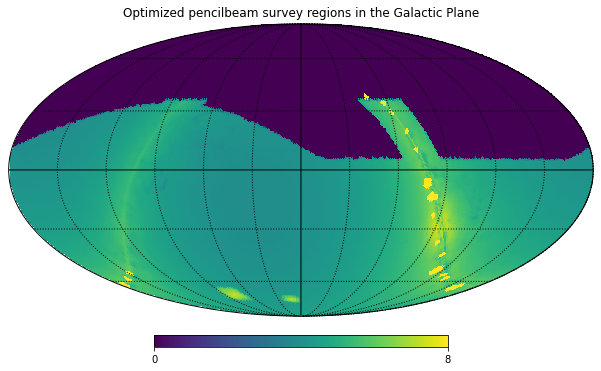

In [34]:
NPIX = hp.nside2npix(NSIDE)
vote_map = hp_log_star_density
vote_map[new_region_pixels] = 8.0
#hp.mollview(hp_log_star_density)
hp.mollview(vote_map, title="Optimized pencilbeam survey regions in the Galactic Plane")
hp.graticule()
plt.tight_layout()
OUTPUT_DIR = '/Users/rstreet1/cassiopeia/Papers/LSST_Cadence_GalPlane'
plt.savefig(path.join(OUTPUT_DIR,'GalPlane_pencilbeams_map.png'))


In [72]:
hp.write_map(path.join(OUTPUT_DIR,'GalPlane_pencilbeams_map.fits'), vote_map, overwrite=True)

setting the output map dtype to [dtype('float64')]


In [27]:
print('Optimized list of field centers, l, b [deg]')
for field in optimized_pointings:
    print(field.l.value, field.b.value)

Optimized list of field centers, l, b [deg]
280.0 0.0
287.280701754386 0.0
295.39473684210526 -0.4166666666666661
306.42543859649123 -0.4166666666666661
306.2061403508772 -0.4166666666666661
320.1535087719298 -0.4166666666666661
324.51754385964915 -0.4166666666666661
341.38157894736844 -0.4166666666666661
351.57894736842104 -2.5
0.10964912280701888 -2.083333333333333
0.3070175438596484 -2.083333333333333
8.421052631578945 -3.333333333333333
17.36842105263159 -0.4166666666666661
26.31578947368422 -2.9166666666666665
44.01315789473685 -0.4166666666666661
44.21052631578948 -0.4166666666666661
54.40789473684211 0.0
66.27192982456141 -0.4166666666666661
71.8859649122807 0.0
80.0 -5.0


For comparison we also consider an alternative set of pencilbeam fields, selected to overlap the Milky Way galactic arms, as identified in Moniez et al (2017) https://www.aanda.org/articles/aa/full_html/2017/08/aa30488-17/aa30488-17.html. 

In [28]:
alt_pencilbeams_list = [
            {'name': 1, 'l_center': 306.56, 'b_center': -1.46, 'radius': 3.91},
            {'name': 2, 'l_center': 331.09, 'b_center': -2.42, 'radius': 3.91},
            {'name': 3, 'l_center': 18.51, 'b_center': -2.09, 'radius': 3.91},
            {'name': 4, 'l_center': 26.60, 'b_center': -2.15, 'radius': 3.91} ]

In [29]:
ahp2 = HEALPix(nside=NSIDE, order='ring', frame=TETE())

In [30]:
for i,field in enumerate(alt_pencilbeams_list):
    pixs = calc_hp_pixels_for_region(field['l_center'], field['b_center'], field['radius'], field['radius'], 500, ahp2)
    if i == 0:
        new_region_pixels = pixs.flatten()
    else:
        new_region_pixels = np.concatenate( (new_region_pixels, pixs.flatten()) )

0.0 180.0 -180.0 180.0
/var/folders/4z/rk7n9jss74g3shm9z6msmyvh0000gp/T/ipykernel_62405/2156117674.py:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


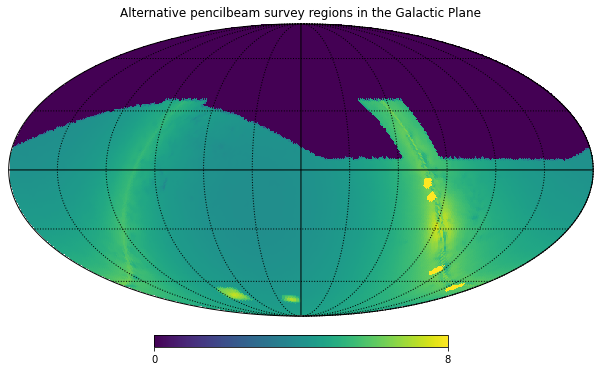

In [38]:
NPIX = hp.nside2npix(NSIDE)
vote_map = copy.copy(star_density_data)
vote_map[new_region_pixels] = 8.0
#hp.mollview(hp_log_star_density)
hp.mollview(vote_map, title="Alternative pencilbeam survey regions in the Galactic Plane")
hp.graticule()
plt.tight_layout()
OUTPUT_DIR = '/Users/rstreet1/cassiopeia/Papers/LSST_Cadence_GalPlane'
plt.savefig(path.join(OUTPUT_DIR,'GalPlane_pencilbeams_alt_map.png'))